
Main problem:
\begin{align}
    \tag{MP}
    \min \quad 
    & \sum_{i \in I j \in J}^n c_{ij} x_{ij} + \sum_{s \in S} p_s \theta_s 
    \\ 
    \text{s.t.} \quad 
    & \mathbf{x} \in \{0,1\}^n, 
    \ \mathbf{\theta_s} \geq 0
\end{align}

we know $\theta_s$ has a lower bound of 0 becuase transportation cost is nonnegative.


Subproblem $s$:
\begin{align}
    \tag{SP($s$)}
    \min \quad 
    & \sum_{j=1}^n \sum_{i=1}^m t_{ij} y_{ij}^s 
    + \sum_{i=1}^m u_i z_{i}^s
    \\
    \text{s.t.} \quad 
    & \Sigma y_{ijk}^s - y_{jik}^s = d_k^s (i \in O_k) \\
    & \Sigma y_{ijk}^s - y_{jik}^s = 0 (i \in D_k)\\
    & \Sigma y_{ijk}^s - y_{jik}^s = 0 (o.w.)\\
    & \sum_{j=1}^n y_{ij}^s + z_i^s \geq d_i^s 
    && \forall \ k \in K
    \\
    & \sum_{i=1}^m y_{ij}^s \leq C_j x_j
    && \forall \ j \in [n]
    \\
    & \mathbf{y}, \mathbf{z} \geq 0
\end{align}

Dual subproblem $s$:
\begin{align}
    \tag{SPD($s$)}
    \max \quad 
    & \sum_{i=1}^m \mu_i^s d_i^s 
    - \sum_{j=1}^n \lambda_j^s C_j x_j
    \\
    \text{s.t.} \quad 
    & \mu_i^s - \lambda_j^s \leq t_{ij} 
    && \forall \ j \in [n], \ i \in [m]
    \\
    & \mu_i^s \leq q_i 
    && \forall \ i \in [m]
    \\
    & \mathbf{\mu}^s, \mathbf{\lambda}^s \geq 0
\end{align}

- If the dual subproblem is unbounded, we obtain an extreme ray $(\mu^*, \lambda^*)$ and add a feasibility cut:
$$ 0 \geq \sum_{i=1}^m \mu^*_i d_i^s - \sum_{j=1}^n \lambda^*_j C_j x_j$$

- If the dual subproblem solves to optimality, we obtain an extreme point $(\mu^*, \lambda^*)$ and add an optimality cut:
$$θ_s \geq \sum_{i=1}^m \mu^*_i d_i^s - \sum_{j=1}^n \lambda^*_j C_j x_j$$

# struct only has data
# method (attached to a class), 

In [1]:
function solve_benders_multi(
    data::FacilityLocationData,#data = FacilityLocationData(50,100,50);
    ;
    verbose::Bool = false,
    time_limit::Int = 180,#(s)
    optimality_gap::Float64 = 1e-4,
)
    """Solve problem using multi-cut Benders decomposition."""
    
    # Define main problem
    MP = Model(() -> Gurobi.Optimizer(GRB_ENV)); #() -> lambdas are closure
    set_optimizer_attributes(
        MP, 
        "TimeLimit" => time_limit, 
        "MIPGap" => optimality_gap, 
        "OutputFlag" => 0,
    )

    n = size(data.facilities, 1)
    m = size(data.customers, 1)
    S = size(data.demand, 2)
    @variable(MP, x[1:I,1:J,1:K], Bin) # multi dim array
    @variable(MP, θ[1:S] ≥ 0)
    @expression(
        MP, 
        fixed_cost,
        sum(data.facility_cost[i] * x[i] for i=1:n) 
    )
    # MP objective
    @objective(
        MP, 
        Min, 
        fixed_cost + sum(data.prob[s] * θ[s] for s in 1:S)
    )
# any infbl sub
    lower_bound_all = []
    upper_bound_all = []
    MP_time = []
    SP_time = []
    while true
        # Solve main problem
        push!(MP_time, @elapsed optimize!(MP))
        lower_bound_new = objective_value(MP)
        push!(lower_bound_all, lower_bound_new)
        x_MP = value.(MP[:x])

        # solve S subproblems
        obj_SP = zeros(S)
        SP_time_all = zeros(S)
        for s = 1:S
            SP_dual = Model(() -> Gurobi.Optimizer(GRB_ENV))
            @suppress set_optimizer_attributes(
                SP_dual, 
                "MIPGap" => optimality_gap, 
                "InfUnbdInfo" => 1, 
                "DualReductions" => 0, 
                "OutputFlag" => 0, 
            )
            @variable(SP_dual, μ[1:N,1:K ] ≥ 0) #pi_ij <=0, mu_i (maybe separate s,t,i mu_s-mu_t = 1)
            @variable(SP_dual, pi [1:N,1:N, 1:K ] <= 0)

            # SPD(s) objective
            @objective(
                SP_dual, 
                Max,
                sum(u_ij pi_ij)
            )
            # SPD(s) constraint 1 
            @constraint(
                SP_dual, 
                [i in 1:N, j in 1:N,], 
                μ[i,j,k] - μ[i,j,k] + pi[i,j,k]  >= 0 
            )
            # SPD(s) constraint 2
            @constraint(
                SP_dual, 
                [i in 1:m], 
                #normalizing s-t =1
            )
            
            SP_time_all[s] = @elapsed optimize!(SP_dual)
            obj_SP_dual = objective_value(SP_dual)
            λ_val = value.(SP_dual[:λ]) -> 
            μ_val = value.(SP_dual[:μ]) -> 
            
            # If dual subproblem is unbounded, add feasibility cut
            if termination_status(SP_dual) == MOI.DUAL_INFEASIBLE
                @constraint(
                    MP, 
                    0 
                    ≥ sum(μ_val[i] * data.demand[i, s] for i in 1:m)
                    - sum(λ_val[j] * data.capacity[j] * x[j] for j in 1:n)
                )
                obj_SP[s] = Inf
            # If dual subproblem is bounded and solves to optimality, add optimality cut
            elseif termination_status(SP_dual) == MOI.OPTIMAL
                @constraint(
                    MP, 
                    θ[s] 
                    ≥ sum(μ_val[i] * data.demand[i, s] for i in 1:m)
                    - sum(λ_val[j] * data.capacity[j] * x[j] for j in 1:n)
                )
                obj_SP[s] = obj_SP_dual
            end
        end

        # Update solve time metrics, upper bound
        push!(SP_time, sum(SP_time_all))
        upper_bound_new = (
            sum(data.facility_cost[j] * x_MP[j] for j in 1:n) 
            + sum(data.prob[s] * obj_SP[s] for s in 1:S)
        )
        push!(upper_bound_all, upper_bound_new)

        if verbose
            @printf("Sol: %.2f - Bound: %.2f\n", upper_bound_all[end], lower_bound_all[end])
        end

        # Termination criteria
        if (
            sum(MP_time) + sum(SP_time) ≥ time_limit 
            || (upper_bound_new - lower_bound_new) / lower_bound_new < optimality_gap
        )
            break
        end
    end
    return upper_bound_all, lower_bound_all, MP_time, SP_time
end

ErrorException: syntax: space before "[" not allowed in "pi [" at /Users/hyunjimoon/Dropbox/tolzul/BayesSD/code/pipeline/prescriptive/IP/hw_moon/hw4/bd.ipynb:60

In [5]:
using DataFrames, CSV
using JuMP, Gurobi
using LinearAlgebra, Random, Printf, StatsBase, CategoricalArrays
using Plots, StatsPlots
using Suppressor
using Distributions
using Distances

const GRB_ENV = Gurobi.Env(output_flag = 0)

df_arcs = DataFrame(CSV.File("ND_arcs.csv"))
transport_cost = DataFrame(CSV.File("ND_transport.csv"))
demand = DataFrame(CSV.File("ND_demand.csv"))
od_matrix = DataFrame(CSV.File("ND_customer_OD.csv"));

arc_ind = df_arcs.x1
arc_i = df_arcs.x2
arc_j = df_arcs.x3
arc_construction_cost = df_arcs.x4
arc_capacity = df_arcs.x5

node_list = Int.(unique(edge_start_node))
prob = ones(size(demand, 2)) * 1/size(demand, 2);

df_edges
edge_start_dict = Dict(i => [] for i in Int.(unique(edge_start_node)))
edge_end_dict = Dict(i => [] for i in Int.(unique(edge_end_node)))
for ind in edge_ind
    s_node = Int(edge_start_node[Int(ind)])
    e_node = Int(edge_end_node[Int(ind)])
    push!(edge_start_dict[s_node], Int(ind))
    push!(edge_end_dict[e_node], Int(ind))
end

TIME_LIMIT = 3600;
OPTIMALITY_GAP = 0.01;
verbose = true;

In [65]:
lower_bound_all

1-element Vector{Any}:
 0.0

In [63]:
minimum(minimum.(upper_bound_all))

MethodError: MethodError: reducing over an empty collection is not allowed; consider supplying `init` to the reducer

In [80]:
no_feasibility_cut = 0
no_optimality_cut = 0
# Define main problem
MP = Model(() -> Gurobi.Optimizer(GRB_ENV));
set_optimizer_attributes(MP, "TimeLimit" => 60, "MIPGap" => 1e-4, "OutputFlag" => 0)
# number of candidate edges is A, scenario is S, demand types (commodity) is K
A = size(edge_ind, 1) #90
S = size(demand, 2) #2
K = size(demand, 1) #3
@variable(MP, x[1:A], Bin)
@variable(MP, θ[1:S] >= 0) # we know the transportation cost is non-negative
@objective(MP, Min, sum(edge_construction_cost[a] * x[a] for a in 1:A) 
                    + sum(prob[s] * θ[s] for s in 1:S))

lower_bound_all = []; upper_bound_all = []; cum_upper_bound_all = [];
MP_time = []; SP_max_time = []; SP_time = []
while true
    # solve master problem
    push!(MP_time, @elapsed optimize!(MP))
    lower_bound_new = objective_value(MP)
    push!(lower_bound_all, lower_bound_new) 
    x_MP = value.(MP[:x])
    # solve S subproblems
    obj_SP = zeros(S)
    SP_time_all = zeros(S)
    for s = 1:S
        SP = Model(() -> Gurobi.Optimizer(GRB_ENV))
        set_optimizer_attributes(SP, "InfUnbdInfo" => 1, "OutputFlag" => 0)
        
        @variable(SP, y[a=1:A, k=1:K] >= 0)
        @constraint(SP, source[k=1:K], sum(y[a,k] for a in edge_start_dict[od_matrix[k,1]])
                    - sum(y[a, k] for a in edge_end_dict[od_matrix[k,1]]) == demand[k,s])
        @constraint(SP, [k=1:K, i in setdiff(node_list, od_matrix[k,:])], sum(y[a,k] for a in edge_start_dict[i])
                    - sum(y[a, k] for a in edge_end_dict[i]) == 0)
        @constraint(SP, sink[k=1:K], sum(y[a,k] for a in edge_start_dict[od_matrix[k,2]])
                    - sum(y[a, k] for a in edge_end_dict[od_matrix[k,2]]) == - demand[k,s])
        @constraint(SP, capacity[a=1:A], - sum(y[a,k] for k in 1:K) >= - edge_capacity[a] * x_MP[a])
        @objective(SP, Min, sum(transport_cost[a,k] * y[a,k] for a in 1:A, k in 1:K))
        
        SP_time_all[s] = @elapsed optimize!(SP)
        SP_obj = objective_value(SP)
        
        α_O_val = dual.(source)
        α_D_val = dual.(sink)
        β_val = dual.(capacity)
        
        if termination_status(SP) == MOI.INFEASIBLE # feasibility cut
            @constraint(MP, sum(demand[k,s]*(α_O_val[k] - α_D_val[k]) for k in 1:K)
                        - sum(edge_capacity[a] * x[a] * β_val[a] for a in 1:A)  <= 0)
            obj_SP[s] = 1e4
            no_feasibility_cut += 1
            print("feasibility_cut", no_feasibility_cut, "\n")
        elseif termination_status(SP) == MOI.OPTIMAL # optimality cut
            @constraint(MP, θ[s] >= sum(demand[k,s]*(α_O_val[k] - α_D_val[k]) for k in 1:K)
                        - sum(edge_capacity[a] * x[a] * β_val[a] for a in 1:A))
            obj_SP[s] = SP_obj
            no_optimality_cut += 1
            print("optimality_cut", no_optimality_cut, "\n")
        end
    end
    push!(SP_max_time, maximum(SP_time_all))
    push!(SP_time, sum(SP_time_all))
    upper_bound_new = sum(edge_construction_cost[a] * x_MP[a] for a=1:A) + sum(prob[s] * obj_SP[s] for s in 1:S) ##
    push!(upper_bound_all,upper_bound_new)
    push!(cum_upper_bound_all, minimum(minimum.(upper_bound_all)))
    verbose && @printf("Sol: %.2f - Bound: %.2f\n", cum_upper_bound_all[end], lower_bound_all[end])
    if sum(MP_time) + sum(SP_time) >= TIME_LIMIT ||
        (upper_bound_new-lower_bound_new)/lower_bound_new < OPTIMALITY_GAP
        break
    end
end

feasibility_cut1
feasibility_cut2
Sol: 10000.00 - Bound: 0.00
feasibility_cut3
feasibility_cut4
Sol: 10000.00 - Bound: 183.90
feasibility_cut5
feasibility_cut6
Sol: 10000.00 - Bound: 384.52
feasibility_cut7
feasibility_cut8
Sol: 10000.00 - Bound: 655.25
feasibility_cut9
feasibility_cut10
Sol: 10000.00 - Bound: 746.93
feasibility_cut11
feasibility_cut12
Sol: 10000.00 - Bound: 806.36
feasibility_cut13
feasibility_cut14
Sol: 10000.00 - Bound: 932.88
feasibility_cut15
feasibility_cut16
Sol: 10000.00 - Bound: 1049.17
feasibility_cut17
feasibility_cut18
Sol: 10000.00 - Bound: 1089.42
feasibility_cut19
feasibility_cut20
Sol: 10000.00 - Bound: 1186.39


feasibility_cut21
feasibility_cut22
Sol: 10000.00 - Bound: 1222.70
feasibility_cut23
feasibility_cut24
Sol: 10000.00 - Bound: 1226.04
feasibility_cut25
feasibility_cut26
Sol: 10000.00 - Bound: 1239.80
feasibility_cut27
feasibility_cut28
Sol: 10000.00 - Bound: 1266.31
feasibility_cut29
feasibility_cut30
Sol: 10000.00 - Bound: 1270.37
feasibility_cut31
feasibility_cut32
Sol: 10000.00 - Bound: 1275.45
feasibility_cut33
feasibility_cut34
Sol: 10000.00 - Bound: 1281.98
feasibility_cut35
feasibility_cut36
Sol: 10000.00 - Bound: 1286.16
feasibility_cut37
feasibility_cut38
Sol: 10000.00 - Bound: 1294.94
feasibility_cut

39
feasibility_cut40
Sol: 10000.00 - Bound: 1310.15
feasibility_cut41
feasibility_cut42
Sol: 10000.00 - Bound: 1316.38
feasibility_cut43
feasibility_cut44
Sol: 10000.00 - Bound: 1323.50
optimality_cut1
optimality_cut2
Sol: 4552.78 - Bound: 1338.90
feasibility_cut45
feasibility_cut46
Sol: 4552.78 - Bound: 1388.94


feasibility_cut47
feasibility_cut48
Sol: 4552.78 - Bound: 1395.20
feasibility_cut49
feasibility_cut50
Sol: 4552.78 - Bound: 1407.93
optimality_cut3
optimality_cut4
Sol: 4213.71 - Bound: 1408.80
feasibility_cut51
feasibility_cut52
Sol: 4213.71 - Bound: 1435.07


feasibility_cut53
feasibility_cut54
Sol: 4213.71 - Bound: 1456.71
feasibility_cut55
feasibility_cut56
Sol: 4213.71 - Bound: 1469.78
feasibility_cut57
feasibility_cut58
Sol: 4213.71 - Bound: 1476.87
feasibility_cut

59
feasibility_cut60
Sol: 4213.71 - Bound: 1478.95
feasibility_cut61
feasibility_cut62
Sol: 4213.71 - Bound: 1487.70
feasibility_cut

63
feasibility_cut64
Sol: 4213.71 - Bound: 1495.32
feasibility_cut65
feasibility_cut66
Sol: 4213.71 - Bound: 1496.16
feasibility_cut67
feasibility_cut68
Sol: 4213.71 - Bound: 1500.56


optimality_cut5
feasibility_cut69
Sol: 4213.71 - Bound: 1501.99
feasibility_cut70
feasibility_cut71
Sol: 4213.71 - Bound: 1512.97
optimality_cut6
optimality_cut7
Sol: 4213.71 - Bound: 1547.38
feasibility_cut

72
feasibility_cut73
Sol: 4213.71 - Bound: 1598.51
feasibility_cut74
feasibility_cut75
Sol: 4213.71 - Bound: 1609.66
feasibility_cut76
feasibility_cut77
Sol: 4213.71 - Bound: 1622.98


feasibility_cut78
feasibility_cut79
Sol: 4213.71 - Bound: 1642.88
optimality_cut8
optimality_cut9
Sol: 4213.71 - Bound: 1644.44


optimality_cut10
optimality_cut11
Sol: 4213.71 - Bound: 2123.14
optimality_cut12
optimality_cut13
Sol: 4213.71 - Bound: 2163.91


optimality_cut14
optimality_cut15
Sol: 4213.71 - Bound: 2250.74
feasibility_cut80
feasibility_cut81
Sol: 4213.71 - Bound: 2317.83


optimality_cut16
optimality_cut17
Sol: 4213.71 - Bound: 2326.96
optimality_cut18
optimality_cut19
Sol: 4213.71 - Bound: 2362.58


optimality_cut20
optimality_cut21
Sol: 4213.71 - Bound: 2399.91
feasibility_cut82
feasibility_cut83
Sol: 4213.71 - Bound: 2477.57


optimality_cut22
optimality_cut23
Sol: 4213.71 - Bound: 2478.85
feasibility_cut

84
feasibility_cut85
Sol: 4213.71 - Bound: 2547.81


optimality_cut24
optimality_cut25
Sol: 4213.71 - Bound: 2567.89
optimality_cut

26
optimality_cut27
Sol: 4213.71 - Bound: 2686.78
optimality_cut28
optimality_cut29
Sol: 4213.71 - Bound: 2963.93
optimality_cut

30
optimality_cut31
Sol: 4213.71 - Bound: 3176.87


optimality_cut32
optimality_cut33
Sol: 4213.71 - Bound: 3220.92
optimality_cut

34
optimality_cut35
Sol: 4213.71 - Bound: 3244.12


optimality_cut36
optimality_cut37
Sol: 4213.71 - Bound: 3269.52
optimality_cut

38
optimality_cut39
Sol: 4213.71 - Bound: 3285.41


optimality_cut40
optimality_cut41
Sol: 4213.71 - Bound: 3292.28
optimality_cut

42
feasibility_cut86
Sol: 4213.71 - Bound: 3366.17


optimality_cut43
optimality_cut44
Sol: 4213.71 - Bound: 3375.39
optimality_cut

45
optimality_cut46
Sol: 4213.71 - Bound: 3433.84


optimality_cut47
optimality_cut48
Sol: 4213.71 - Bound: 3537.02
optimality_cut

49
optimality_cut50
Sol: 4213.71 - Bound: 3558.98


optimality_cut51
optimality_cut52
Sol: 4213.71 - Bound: 3560.02
optimality_cut

53
optimality_cut54
Sol: 4213.71 - Bound: 3661.63


optimality_cut55
feasibility_cut87
Sol: 4213.71 - Bound: 3688.59
optimality_cut

56
optimality_cut57
Sol: 4213.71 - Bound: 3690.78


optimality_cut58
optimality_cut59
Sol: 4213.71 - Bound: 3740.64
optimality_cut

60
optimality_cut61
Sol: 4213.71 - Bound: 3763.19


optimality_cut62
optimality_cut63
Sol: 4213.71 - Bound: 3773.47
feasibility_cut

88
feasibility_cut89
Sol: 4213.71 - Bound: 3799.03


optimality_cut64
optimality_cut65
Sol: 4213.71 - Bound: 3815.04
optimality_cut

66
optimality_cut67
Sol: 4213.71 - Bound: 3945.76


feasibility_cut90
feasibility_cut91
Sol: 4213.71 - Bound: 3986.37
optimality_cut

68
optimality_cut69
Sol: 4213.71 - Bound: 4000.13


optimality_cut70
optimality_cut71
Sol: 4213.71 - Bound: 4004.43
optimality_cut

72
optimality_cut73
Sol: 4213.71 - Bound: 4021.71


optimality_cut74
optimality_cut75
Sol: 4213.71 - Bound: 4036.46
optimality_cut

76
optimality_cut77
Sol: 4213.71 - Bound: 4047.37


optimality_cut78
optimality_cut79
Sol: 4213.71 - Bound: 4060.10
optimality_cut

80
optimality_cut81
Sol: 4066.53 - Bound: 4066.53


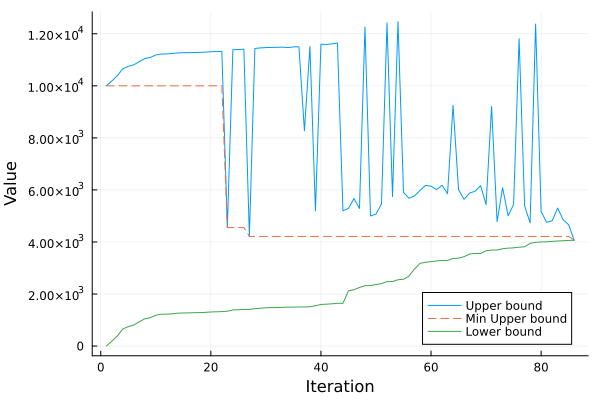

In [81]:
plot(
    [upper_bound_all, cum_upper_bound_all, lower_bound_all], 
    label = ["Upper bound" "Min Upper bound" "Lower bound"], 
    linestyle = [:solid :dash],
    xlabel = "Iteration",
    ylabel = "Value",
) 

In [82]:
no_optimality_cut 


81

In [83]:
no_feasibility_cut 

91